In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import time

# üö® PIPELINE EXPL√çCITO: RASTREAMENTO COMPLETO DE FEATURES

## Estrat√©gia de Corre√ß√£o:
1. **Pipeline Expl√≠cito**: Cada dataframe tem nome √∫nico e descritivo
2. **Auditoria de Penhascos**: Identificar exatamente onde features s√£o perdidas
3. **Checkpoints com .info()**: Inspe√ß√£o detalhada em cada etapa
4. **Preserva√ß√£o Rigorosa**: Garantir que nenhuma feature seja perdida

## Nomenclatura do Pipeline:
- `df_step01_raw`: Dados brutos carregados
- `df_step02_processed`: Dados processados b√°sicos
- `df_step03_features`: Com features t√©cnicas criadas
- `df_step04_selected`: Ap√≥s sele√ß√£o de features
- `df_step05_temporal`: Ap√≥s corre√ß√£o temporal
- `df_step06_candlestick`: Com padr√µes de candlestick
- `df_step07_final`: Dataset final para modelagem

In [2]:
# FUN√á√ÉO DE AUDITORIA RIGOROSA
def audit_pipeline_step(df, step_name, expected_min_cols=None, previous_df=None):
    """
    Auditoria rigorosa de cada etapa do pipeline
    Identifica exatamente onde features s√£o perdidas
    """
    print(f"\n{'='*60}")
    print(f"üîç AUDITORIA: {step_name.upper()}")
    print(f"{'='*60}")
    
    # Informa√ß√µes b√°sicas
    print(f"üìä INFORMA√á√ïES B√ÅSICAS:")
    print(f"   Shape: {df.shape}")
    print(f"   Mem√≥ria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Usar .info() para inspe√ß√£o detalhada
    print(f"\nüìã DETALHES DAS COLUNAS (.info()):")
    df.info()
    
    # Categoriza√ß√£o de features
    ohlc_cols = [col for col in df.columns if col in ['Abertura', 'M√°xima', 'M√≠nima', '√öltimo', 'Volume']]
    temporal_cols = [col for col in df.columns if any(x in col.lower() for x in ['data', 'day', 'month', 'quarter', 'year'])]
    technical_cols = [col for col in df.columns if any(x in col.lower() for x in ['ma_', 'bb_', 'rsi', 'atr', 'volatility', 'macd'])]
    shifted_cols = [col for col in df.columns if col.endswith('_shifted')]
    candlestick_cols = [col for col in df.columns if any(x in col.lower() for x in ['doji', 'hammer', 'engulf', 'marubozu', 'shooting', '_prev'])]
    target_cols = [col for col in df.columns if 'target' in col.lower()]
    other_cols = [col for col in df.columns if col not in ohlc_cols + temporal_cols + technical_cols + shifted_cols + candlestick_cols + target_cols]
    
    print(f"\nüìÇ CATEGORIZA√á√ÉO DE FEATURES:")
    print(f"   üè¢ OHLC/Volume ({len(ohlc_cols)}): {ohlc_cols}")
    print(f"   üìÖ Temporais ({len(temporal_cols)}): {temporal_cols}")
    print(f"   üìà T√©cnicas ({len(technical_cols)}): {technical_cols[:5]}{'...' if len(technical_cols) > 5 else ''}")
    print(f"   ‚è∞ Shifted ({len(shifted_cols)}): {shifted_cols[:5]}{'...' if len(shifted_cols) > 5 else ''}")
    print(f"   üïØÔ∏è Candlestick ({len(candlestick_cols)}): {candlestick_cols[:5]}{'...' if len(candlestick_cols) > 5 else ''}")
    print(f"   üéØ Target ({len(target_cols)}): {target_cols}")
    print(f"   ‚ùì Outras ({len(other_cols)}): {other_cols[:5]}{'...' if len(other_cols) > 5 else ''}")
    
    # Verificar se h√° perda de features
    if previous_df is not None:
        print(f"\nüö® AN√ÅLISE DE MUDAN√áAS:")
        prev_cols = set(previous_df.columns)
        curr_cols = set(df.columns)
        
        lost_features = prev_cols - curr_cols
        gained_features = curr_cols - prev_cols
        
        print(f"   üìâ Features PERDIDAS ({len(lost_features)}):")
        if lost_features:
            for feature in sorted(lost_features):
                print(f"      ‚ùå {feature}")
        else:
            print(f"      ‚úÖ Nenhuma feature perdida")
        
        print(f"   üìà Features GANHAS ({len(gained_features)}):")
        if gained_features:
            for feature in sorted(gained_features):
                print(f"      ‚úÖ {feature}")
        else:
            print(f"      ‚ûñ Nenhuma feature ganha")
        
        net_change = len(curr_cols) - len(prev_cols)
        print(f"   üìä Mudan√ßa l√≠quida: {net_change:+d} features")
        
        # ALERTA para perdas significativas
        if len(lost_features) > 5:
            print(f"\nüö® ALERTA: PERDA SIGNIFICATIVA DE FEATURES!")
            print(f"   {len(lost_features)} features foram perdidas nesta etapa")
            print(f"   Isso pode indicar um 'PENHASCO' no pipeline")
    
    # Verificar expectativas
    if expected_min_cols and len(df.columns) < expected_min_cols:
        print(f"\n‚ö†Ô∏è AVISO: Menos colunas que esperado")
        print(f"   Esperado: >= {expected_min_cols}")
        print(f"   Atual: {len(df.columns)}")
    
    # Verificar qualidade dos dados
    print(f"\nüîç QUALIDADE DOS DADOS:")
    null_counts = df.isnull().sum()
    cols_with_nulls = null_counts[null_counts > 0]
    print(f"   Colunas com valores ausentes: {len(cols_with_nulls)}")
    if len(cols_with_nulls) > 0:
        print(f"   Top 5 com mais NaNs:")
        for col, count in cols_with_nulls.head().items():
            print(f"      {col}: {count} ({count/len(df):.1%})")
    
    print(f"\n‚úÖ Auditoria de {step_name} conclu√≠da")
    print(f"{'='*60}")
    
    return {
        'step_name': step_name,
        'shape': df.shape,
        'columns': list(df.columns),
        'ohlc_count': len(ohlc_cols),
        'technical_count': len(technical_cols),
        'shifted_count': len(shifted_cols),
        'candlestick_count': len(candlestick_cols)
    }

print("‚úÖ Fun√ß√£o de auditoria rigorosa criada")
print("üìã Pronta para rastrear cada etapa do pipeline")

‚úÖ Fun√ß√£o de auditoria rigorosa criada
üìã Pronta para rastrear cada etapa do pipeline


## STEP 01: CARREGAMENTO DOS DADOS BRUTOS

In [3]:
# STEP 01: CARREGAMENTO DOS DADOS BRUTOS
print("üöÄ INICIANDO PIPELINE EXPL√çCITO")
print("üìÇ STEP 01: Carregando dados brutos...")

# Carregar dados brutos
df_step01_raw = pd.read_csv('Dados Hist√≥ricos - Ibovespa.csv', encoding='utf-8')

# Auditoria do carregamento
audit_step01 = audit_pipeline_step(df_step01_raw, "STEP 01 - Dados Brutos")

print(f"\nüìã RESUMO STEP 01:")
print(f"   ‚úÖ Dados carregados: {df_step01_raw.shape}")
print(f"   üìä Colunas originais: {list(df_step01_raw.columns)}")

üöÄ INICIANDO PIPELINE EXPL√çCITO
üìÇ STEP 01: Carregando dados brutos...

üîç AUDITORIA: STEP 01 - DADOS BRUTOS
üìä INFORMA√á√ïES B√ÅSICAS:
   Shape: (3592, 7)
   Mem√≥ria: 0.68 MB

üìã DETALHES DAS COLUNAS (.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3592 entries, 0 to 3591
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      3592 non-null   object 
 1   √öltimo    3592 non-null   float64
 2   Abertura  3592 non-null   float64
 3   M√°xima    3592 non-null   float64
 4   M√≠nima    3592 non-null   float64
 5   Vol.      3591 non-null   object 
 6   Var%      3592 non-null   object 
dtypes: float64(4), object(3)
memory usage: 196.6+ KB

üìÇ CATEGORIZA√á√ÉO DE FEATURES:
   üè¢ OHLC/Volume (4): ['√öltimo', 'Abertura', 'M√°xima', 'M√≠nima']
   üìÖ Temporais (1): ['Data']
   üìà T√©cnicas (0): []
   ‚è∞ Shifted (0): []
   üïØÔ∏è Candlestick (0): []
   üéØ Target (0): []
   ‚ùì Outras (2): ['

## STEP 02: PROCESSAMENTO B√ÅSICO

In [4]:
# STEP 02: PROCESSAMENTO B√ÅSICO
print("\nüìÇ STEP 02: Processamento b√°sico...")

# Criar c√≥pia para processamento
df_step02_processed = df_step01_raw.copy()

# Processamento de data
df_step02_processed['Data'] = pd.to_datetime(df_step02_processed['Data'], format='%d.%m.%Y')
df_step02_processed = df_step02_processed.sort_values('Data').reset_index(drop=True)

# Tratar valores ausentes
df_step02_processed['Vol.'] = df_step02_processed['Vol.'].fillna(method='ffill')

# Converter Volume para num√©rico
def converter_volume(vol_str):
    if pd.isna(vol_str): return np.nan
    vol_str = str(vol_str).replace(',', '.')
    if 'B' in vol_str: return float(vol_str.replace('B', '')) * 1e9
    elif 'M' in vol_str: return float(vol_str.replace('M', '')) * 1e6
    elif 'K' in vol_str: return float(vol_str.replace('K', '')) * 1e3
    return float(vol_str)

df_step02_processed['Volume'] = df_step02_processed['Vol.'].apply(converter_volume)
df_step02_processed['Variacao'] = df_step02_processed['Var%'].str.replace('%', '').str.replace(',', '.').astype(float) / 100

# Criar target
df_step02_processed['Target'] = (df_step02_processed['Variacao'].shift(-1) > 0).astype(int)
df_step02_processed = df_step02_processed[:-1].copy()  # Remove √∫ltima linha

# Auditoria do processamento
audit_step02 = audit_pipeline_step(
    df_step02_processed, 
    "STEP 02 - Processamento B√°sico", 
    expected_min_cols=len(df_step01_raw.columns),
    previous_df=df_step01_raw
)

print(f"\nüìã RESUMO STEP 02:")
print(f"   ‚úÖ Target criado corretamente")
print(f"   üìä Shape ap√≥s processamento: {df_step02_processed.shape}")
print(f"   üéØ Distribui√ß√£o do target:")
print(df_step02_processed['Target'].value_counts(normalize=True))


üìÇ STEP 02: Processamento b√°sico...

üîç AUDITORIA: STEP 02 - PROCESSAMENTO B√ÅSICO
üìä INFORMA√á√ïES B√ÅSICAS:
   Shape: (3591, 10)
   Mem√≥ria: 0.59 MB

üìã DETALHES DAS COLUNAS (.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591 entries, 0 to 3590
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      3591 non-null   datetime64[ns]
 1   √öltimo    3591 non-null   float64       
 2   Abertura  3591 non-null   float64       
 3   M√°xima    3591 non-null   float64       
 4   M√≠nima    3591 non-null   float64       
 5   Vol.      3591 non-null   object        
 6   Var%      3591 non-null   object        
 7   Volume    3591 non-null   float64       
 8   Variacao  3591 non-null   float64       
 9   Target    3591 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 280.7+ KB

üìÇ CATEGORIZA√á√ÉO DE FEATURES:
   üè¢ OHLC/Volume (5

## STEP 03: CRIA√á√ÉO DE FEATURES T√âCNICAS

In [5]:
# STEP 03: CRIA√á√ÉO DE FEATURES T√âCNICAS
print("\nüìÇ STEP 03: Criando features t√©cnicas...")

# Criar c√≥pia para features
df_step03_features = df_step02_processed.copy()

print("üìà Criando indicadores t√©cnicos...")

# M√©dias m√≥veis
for periodo in [5, 10, 20, 50]:
    df_step03_features[f'MA_{periodo}'] = df_step03_features['√öltimo'].rolling(window=periodo).mean()

# Bandas de Bollinger
df_step03_features['BB_Middle'] = df_step03_features['√öltimo'].rolling(window=20).mean()
bb_std = df_step03_features['√öltimo'].rolling(window=20).std()
df_step03_features['BB_Upper'] = df_step03_features['BB_Middle'] + (bb_std * 2)
df_step03_features['BB_Lower'] = df_step03_features['BB_Middle'] - (bb_std * 2)
df_step03_features['BB_Width'] = df_step03_features['BB_Upper'] - df_step03_features['BB_Lower']
df_step03_features['BB_Position'] = (df_step03_features['√öltimo'] - df_step03_features['BB_Lower']) / df_step03_features['BB_Width']

# RSI
def calculate_rsi(prices, window=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

df_step03_features['RSI'] = calculate_rsi(df_step03_features['√öltimo'])

# MACD
ema_12 = df_step03_features['√öltimo'].ewm(span=12).mean()
ema_26 = df_step03_features['√öltimo'].ewm(span=26).mean()
df_step03_features['MACD'] = ema_12 - ema_26
df_step03_features['Signal_Line'] = df_step03_features['MACD'].ewm(span=9).mean()

# ATR (Average True Range)
df_step03_features['high_low'] = df_step03_features['M√°xima'] - df_step03_features['M√≠nima']
df_step03_features['high_close_prev'] = abs(df_step03_features['M√°xima'] - df_step03_features['√öltimo'].shift(1))
df_step03_features['low_close_prev'] = abs(df_step03_features['M√≠nima'] - df_step03_features['√öltimo'].shift(1))
df_step03_features['true_range'] = df_step03_features[['high_low', 'high_close_prev', 'low_close_prev']].max(axis=1)

for periodo in [5, 10, 20]:
    df_step03_features[f'atr_{periodo}'] = df_step03_features['true_range'].rolling(window=periodo).mean()

# Volatilidade
df_step03_features['returns'] = df_step03_features['√öltimo'].pct_change()
for periodo in [5, 10, 20]:
    df_step03_features[f'volatility_{periodo}'] = df_step03_features['returns'].rolling(window=periodo).std()

# Features de pre√ßo
df_step03_features['Price_Range'] = df_step03_features['M√°xima'] - df_step03_features['M√≠nima']
df_step03_features['Price_Position'] = (df_step03_features['√öltimo'] - df_step03_features['M√≠nima']) / df_step03_features['Price_Range']
df_step03_features['Gap'] = df_step03_features['Abertura'] - df_step03_features['√öltimo'].shift(1)
df_step03_features['hl_close_ratio'] = (df_step03_features['M√°xima'] - df_step03_features['M√≠nima']) / df_step03_features['√öltimo']

# Features temporais
df_step03_features['day_of_week'] = df_step03_features['Data'].dt.dayofweek
df_step03_features['month'] = df_step03_features['Data'].dt.month
df_step03_features['quarter'] = df_step03_features['Data'].dt.quarter
df_step03_features['year'] = df_step03_features['Data'].dt.year
df_step03_features['is_month_start'] = (df_step03_features['Data'].dt.day <= 5).astype(int)
df_step03_features['is_month_end'] = (df_step03_features['Data'].dt.day >= 25).astype(int)
df_step03_features['is_quarter_end'] = df_step03_features['Data'].dt.is_quarter_end.astype(int)

# Auditoria da cria√ß√£o de features
audit_step03 = audit_pipeline_step(
    df_step03_features, 
    "STEP 03 - Features T√©cnicas", 
    expected_min_cols=30,  # Esperamos pelo menos 30 features
    previous_df=df_step02_processed
)

print(f"\nüìã RESUMO STEP 03:")
print(f"   ‚úÖ Features t√©cnicas criadas: {df_step03_features.shape[1] - df_step02_processed.shape[1]}")
print(f"   üìä Total de features: {df_step03_features.shape[1]}")
print(f"   üéØ Shape final: {df_step03_features.shape}")


üìÇ STEP 03: Criando features t√©cnicas...
üìà Criando indicadores t√©cnicos...

üîç AUDITORIA: STEP 03 - FEATURES T√âCNICAS
üìä INFORMA√á√ïES B√ÅSICAS:
   Shape: (3591, 44)
   Mem√≥ria: 1.47 MB

üìã DETALHES DAS COLUNAS (.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591 entries, 0 to 3590
Data columns (total 44 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Data             3591 non-null   datetime64[ns]
 1   √öltimo           3591 non-null   float64       
 2   Abertura         3591 non-null   float64       
 3   M√°xima           3591 non-null   float64       
 4   M√≠nima           3591 non-null   float64       
 5   Vol.             3591 non-null   object        
 6   Var%             3591 non-null   object        
 7   Volume           3591 non-null   float64       
 8   Variacao         3591 non-null   float64       
 9   Target           3591 non-null   int64         
 10  MA_5       

## STEP 04: SELE√á√ÉO DE FEATURES (PONTO CR√çTICO)

In [6]:
# STEP 04: SELE√á√ÉO DE FEATURES - PONTO CR√çTICO!
print("\nüìÇ STEP 04: Sele√ß√£o de features (PONTO CR√çTICO)...")
print("üö® ATEN√á√ÉO: Esta √© uma √°rea comum para 'PENHASCOS' de features!")

# ANTES da sele√ß√£o - checkpoint cr√≠tico
print(f"\nüîç CHECKPOINT ANTES DA SELE√á√ÉO:")
print(f"   Features dispon√≠veis: {df_step03_features.shape[1]}")
print(f"   Primeiras 10: {list(df_step03_features.columns)[:10]}")
print(f"   √öltimas 10: {list(df_step03_features.columns)[-10:]}")

# Criar c√≥pia para sele√ß√£o
df_step04_selected = df_step03_features.copy()

# ESTRAT√âGIA CONSERVADORA: Manter TODAS as features criadas
# Apenas remover colunas auxiliares e duplicadas
columns_to_remove = [
    'Vol.',  # Vers√£o string do volume
    'Var%',  # Vers√£o string da varia√ß√£o
    'high_low',  # Auxiliar para ATR
    'BB_Middle'  # Duplicata da MA_20
]

# Remover apenas colunas auxiliares
columns_to_remove_existing = [col for col in columns_to_remove if col in df_step04_selected.columns]
if columns_to_remove_existing:
    print(f"\nüóëÔ∏è Removendo apenas colunas auxiliares: {columns_to_remove_existing}")
    df_step04_selected = df_step04_selected.drop(columns=columns_to_remove_existing)
else:
    print(f"\n‚úÖ Nenhuma coluna auxiliar para remover")

# CHECKPOINT CR√çTICO: Verificar se n√£o perdemos features importantes
features_importantes = [
    'Abertura', 'M√°xima', 'M√≠nima', '√öltimo', 'Volume',
    'MA_5', 'MA_10', 'MA_20', 'MA_50',
    'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position',
    'RSI', 'MACD', 'Signal_Line',
    'atr_5', 'atr_10', 'atr_20',
    'volatility_5', 'volatility_10', 'volatility_20',
    'Price_Range', 'Price_Position', 'Gap', 'hl_close_ratio',
    'day_of_week', 'month', 'quarter', 'year',
    'is_month_start', 'is_month_end', 'is_quarter_end',
    'Target'
]

features_perdidas = [f for f in features_importantes if f not in df_step04_selected.columns]
if features_perdidas:
    print(f"\nüö® ALERTA: Features importantes perdidas: {features_perdidas}")
else:
    print(f"\n‚úÖ Todas as features importantes preservadas")

# Auditoria da sele√ß√£o
audit_step04 = audit_pipeline_step(
    df_step04_selected, 
    "STEP 04 - Sele√ß√£o de Features", 
    expected_min_cols=len(features_importantes),
    previous_df=df_step03_features
)

print(f"\nüìã RESUMO STEP 04:")
print(f"   ‚úÖ Features selecionadas: {df_step04_selected.shape[1]}")
print(f"   üìä Features removidas: {df_step03_features.shape[1] - df_step04_selected.shape[1]}")
print(f"   üéØ Shape final: {df_step04_selected.shape}")


üìÇ STEP 04: Sele√ß√£o de features (PONTO CR√çTICO)...
üö® ATEN√á√ÉO: Esta √© uma √°rea comum para 'PENHASCOS' de features!

üîç CHECKPOINT ANTES DA SELE√á√ÉO:
   Features dispon√≠veis: 44
   Primeiras 10: ['Data', '√öltimo', 'Abertura', 'M√°xima', 'M√≠nima', 'Vol.', 'Var%', 'Volume', 'Variacao', 'Target']
   √öltimas 10: ['Price_Position', 'Gap', 'hl_close_ratio', 'day_of_week', 'month', 'quarter', 'year', 'is_month_start', 'is_month_end', 'is_quarter_end']

üóëÔ∏è Removendo apenas colunas auxiliares: ['Vol.', 'Var%', 'high_low', 'BB_Middle']

‚úÖ Todas as features importantes preservadas

üîç AUDITORIA: STEP 04 - SELE√á√ÉO DE FEATURES
üìä INFORMA√á√ïES B√ÅSICAS:
   Shape: (3591, 40)
   Mem√≥ria: 1.04 MB

üìã DETALHES DAS COLUNAS (.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591 entries, 0 to 3590
Data columns (total 40 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Data             3591 

## STEP 05: CORRE√á√ÉO TEMPORAL (PENHASCO CR√çTICO!)

In [7]:
# STEP 05: CORRE√á√ÉO TEMPORAL - PENHASCO CR√çTICO!
print("\nüìÇ STEP 05: Corre√ß√£o temporal (PENHASCO CR√çTICO!)...")
print("üö® ATEN√á√ÉO: Esta √© a √°rea mais prov√°vel para perda massiva de features!")

# CHECKPOINT ANTES DA CORRE√á√ÉO TEMPORAL
print(f"\nüîç CHECKPOINT ANTES DA CORRE√á√ÉO TEMPORAL:")
print(f"   Features dispon√≠veis: {df_step04_selected.shape[1]}")
print(f"   Shape: {df_step04_selected.shape}")

# Criar c√≥pia para corre√ß√£o temporal
df_step05_temporal = df_step04_selected.copy()

# ESTRAT√âGIA CONSERVADORA: Aplicar shift apenas onde necess√°rio
# Identificar features que precisam de shift (dados do presente/futuro)
features_to_shift = [
    'Abertura', 'M√°xima', 'M√≠nima', '√öltimo', 'Volume',
    'MA_5', 'MA_10', 'MA_20', 'MA_50',
    'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position',
    'RSI', 'MACD', 'Signal_Line',
    'atr_5', 'atr_10', 'atr_20',
    'volatility_5', 'volatility_10', 'volatility_20',
    'Price_Range', 'Price_Position', 'Gap', 'hl_close_ratio',
    'true_range', 'high_close_prev', 'low_close_prev',
    'returns', 'Variacao'
]

# Features que N√ÉO precisam de shift (dados temporais do passado)
features_no_shift = [
    'Data', 'day_of_week', 'month', 'quarter', 'year',
    'is_month_start', 'is_month_end', 'is_quarter_end',
    'Target'
]

# Verificar quais features est√£o dispon√≠veis
available_to_shift = [f for f in features_to_shift if f in df_step05_temporal.columns]
available_no_shift = [f for f in features_no_shift if f in df_step05_temporal.columns]

print(f"\nüìä AN√ÅLISE DE FEATURES PARA SHIFT:")
print(f"   Features para shift: {len(available_to_shift)} de {len(features_to_shift)}")
print(f"   Features sem shift: {len(available_no_shift)} de {len(features_no_shift)}")

missing_to_shift = [f for f in features_to_shift if f not in df_step05_temporal.columns]
if missing_to_shift:
    print(f"   ‚ö†Ô∏è Features ausentes para shift: {missing_to_shift}")

# APLICAR SHIFT DE FORMA CONSERVADORA
print(f"\n‚è∞ Aplicando shift temporal...")

# Criar dataset final com features shifted
df_temporal_final = pd.DataFrame()

# 1. Manter features temporais sem shift
for feature in available_no_shift:
    df_temporal_final[feature] = df_step05_temporal[feature]

# 2. Aplicar shift nas features de pre√ßo/indicadores
for feature in available_to_shift:
    df_temporal_final[f'{feature}_shifted'] = df_step05_temporal[feature].shift(1)

# 3. Remover primeira linha (NaN devido ao shift)
df_temporal_final = df_temporal_final.iloc[1:].reset_index(drop=True)

# CHECKPOINT CR√çTICO AP√ìS CORRE√á√ÉO TEMPORAL
print(f"\nüîç CHECKPOINT AP√ìS CORRE√á√ÉO TEMPORAL:")
print(f"   Features antes: {df_step05_temporal.shape[1]}")
print(f"   Features depois: {df_temporal_final.shape[1]}")
print(f"   Mudan√ßa: {df_temporal_final.shape[1] - df_step05_temporal.shape[1]:+d}")

# Verificar se temos as features shifted esperadas
expected_shifted = [f'{f}_shifted' for f in available_to_shift]
actual_shifted = [col for col in df_temporal_final.columns if col.endswith('_shifted')]

print(f"\nüìä VERIFICA√á√ÉO DE FEATURES SHIFTED:")
print(f"   Esperadas: {len(expected_shifted)}")
print(f"   Criadas: {len(actual_shifted)}")

missing_shifted = [f for f in expected_shifted if f not in df_temporal_final.columns]
if missing_shifted:
    print(f"   ‚ùå Features shifted ausentes: {missing_shifted[:5]}{'...' if len(missing_shifted) > 5 else ''}")
else:
    print(f"   ‚úÖ Todas as features shifted criadas corretamente")

# Atualizar vari√°vel para pr√≥xima etapa
df_step05_temporal = df_temporal_final.copy()

# Auditoria da corre√ß√£o temporal
audit_step05 = audit_pipeline_step(
    df_step05_temporal, 
    "STEP 05 - Corre√ß√£o Temporal", 
    expected_min_cols=len(available_no_shift) + len(available_to_shift),
    previous_df=df_step04_selected
)

print(f"\nüìã RESUMO STEP 05:")
print(f"   ‚úÖ Corre√ß√£o temporal aplicada")
print(f"   üìä Features shifted criadas: {len(actual_shifted)}")
print(f"   üéØ Shape final: {df_step05_temporal.shape}")


üìÇ STEP 05: Corre√ß√£o temporal (PENHASCO CR√çTICO!)...
üö® ATEN√á√ÉO: Esta √© a √°rea mais prov√°vel para perda massiva de features!

üîç CHECKPOINT ANTES DA CORRE√á√ÉO TEMPORAL:
   Features dispon√≠veis: 40
   Shape: (3591, 40)

üìä AN√ÅLISE DE FEATURES PARA SHIFT:
   Features para shift: 31 de 31
   Features sem shift: 9 de 9

‚è∞ Aplicando shift temporal...

üîç CHECKPOINT AP√ìS CORRE√á√ÉO TEMPORAL:
   Features antes: 40
   Features depois: 40
   Mudan√ßa: +0

üìä VERIFICA√á√ÉO DE FEATURES SHIFTED:
   Esperadas: 31
   Criadas: 31
   ‚úÖ Todas as features shifted criadas corretamente

üîç AUDITORIA: STEP 05 - CORRE√á√ÉO TEMPORAL
üìä INFORMA√á√ïES B√ÅSICAS:
   Shape: (3590, 40)
   Mem√≥ria: 1.04 MB

üìã DETALHES DAS COLUNAS (.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3590 entries, 0 to 3589
Data columns (total 40 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Data    

## STEP 06: PADR√ïES DE CANDLESTICK

In [8]:
# STEP 06: PADR√ïES DE CANDLESTICK
print("\nüìÇ STEP 06: Criando padr√µes de candlestick...")

# Criar c√≥pia para candlestick
df_step06_candlestick = df_step05_temporal.copy()

# Verificar se temos as colunas OHLC shifted necess√°rias
ohlc_shifted_cols = ['Abertura_shifted', 'M√°xima_shifted', 'M√≠nima_shifted', '√öltimo_shifted']
available_ohlc_shifted = [col for col in ohlc_shifted_cols if col in df_step06_candlestick.columns]

print(f"\nüïØÔ∏è VERIFICA√á√ÉO DE COLUNAS OHLC SHIFTED:")
print(f"   Necess√°rias: {ohlc_shifted_cols}")
print(f"   Dispon√≠veis: {available_ohlc_shifted}")

if len(available_ohlc_shifted) == 4:
    print(f"   ‚úÖ Todas as colunas OHLC shifted dispon√≠veis")
    
    # Renomear temporariamente para facilitar c√°lculos
    ohlc_temp = df_step06_candlestick[available_ohlc_shifted].copy()
    ohlc_temp.columns = ['Open', 'High', 'Low', 'Close']
    
    # Fun√ß√µes de padr√µes de candlestick
    def detect_doji(df, threshold=0.1):
        body_size = abs(df['Close'] - df['Open'])
        total_range = df['High'] - df['Low']
        return (body_size / total_range < threshold).astype(int)
    
    def detect_hammer(df):
        body_size = abs(df['Close'] - df['Open'])
        lower_shadow = df[['Open', 'Close']].min(axis=1) - df['Low']
        upper_shadow = df['High'] - df[['Open', 'Close']].max(axis=1)
        return ((lower_shadow > 2 * body_size) & (upper_shadow < body_size)).astype(int)
    
    def detect_shooting_star(df):
        body_size = abs(df['Close'] - df['Open'])
        lower_shadow = df[['Open', 'Close']].min(axis=1) - df['Low']
        upper_shadow = df['High'] - df[['Open', 'Close']].max(axis=1)
        return ((upper_shadow > 2 * body_size) & (lower_shadow < body_size)).astype(int)
    
    def detect_engulfing_bullish(df):
        current_bullish = df['Close'] > df['Open']
        prev_bearish = (df['Close'].shift(1) < df['Open'].shift(1))
        current_open_below_prev_close = df['Open'] < df['Close'].shift(1)
        current_close_above_prev_open = df['Close'] > df['Open'].shift(1)
        return (current_bullish & prev_bearish & current_open_below_prev_close & current_close_above_prev_open).astype(int)
    
    # Aplicar padr√µes
    print(f"\nüìä Criando padr√µes de candlestick...")
    
    df_step06_candlestick['doji_prev'] = detect_doji(ohlc_temp)
    df_step06_candlestick['hammer_prev'] = detect_hammer(ohlc_temp)
    df_step06_candlestick['shooting_star_prev'] = detect_shooting_star(ohlc_temp)
    df_step06_candlestick['engulfing_bullish_prev'] = detect_engulfing_bullish(ohlc_temp)
    
    # Padr√µes adicionais
    df_step06_candlestick['bullish_candle_prev'] = (ohlc_temp['Close'] > ohlc_temp['Open']).astype(int)
    df_step06_candlestick['bearish_candle_prev'] = (ohlc_temp['Close'] < ohlc_temp['Open']).astype(int)
    
    # M√©tricas de candlestick
    df_step06_candlestick['body_size_prev'] = abs(ohlc_temp['Close'] - ohlc_temp['Open'])
    df_step06_candlestick['upper_shadow_prev'] = ohlc_temp['High'] - ohlc_temp[['Open', 'Close']].max(axis=1)
    df_step06_candlestick['lower_shadow_prev'] = ohlc_temp[['Open', 'Close']].min(axis=1) - ohlc_temp['Low']
    
    candlestick_features_created = 9
    print(f"   ‚úÖ {candlestick_features_created} features de candlestick criadas")
    
else:
    print(f"   ‚ùå Colunas OHLC shifted insuficientes")
    print(f"   Ausentes: {[col for col in ohlc_shifted_cols if col not in df_step06_candlestick.columns]}")
    candlestick_features_created = 0

# Auditoria dos padr√µes de candlestick
audit_step06 = audit_pipeline_step(
    df_step06_candlestick, 
    "STEP 06 - Padr√µes de Candlestick", 
    expected_min_cols=df_step05_temporal.shape[1] + candlestick_features_created,
    previous_df=df_step05_temporal
)

print(f"\nüìã RESUMO STEP 06:")
print(f"   ‚úÖ Features de candlestick criadas: {candlestick_features_created}")
print(f"   üìä Total de features: {df_step06_candlestick.shape[1]}")
print(f"   üéØ Shape final: {df_step06_candlestick.shape}")


üìÇ STEP 06: Criando padr√µes de candlestick...

üïØÔ∏è VERIFICA√á√ÉO DE COLUNAS OHLC SHIFTED:
   Necess√°rias: ['Abertura_shifted', 'M√°xima_shifted', 'M√≠nima_shifted', '√öltimo_shifted']
   Dispon√≠veis: ['Abertura_shifted', 'M√°xima_shifted', 'M√≠nima_shifted', '√öltimo_shifted']
   ‚úÖ Todas as colunas OHLC shifted dispon√≠veis

üìä Criando padr√µes de candlestick...
   ‚úÖ 9 features de candlestick criadas

üîç AUDITORIA: STEP 06 - PADR√ïES DE CANDLESTICK
üìä INFORMA√á√ïES B√ÅSICAS:
   Shape: (3590, 49)
   Mem√≥ria: 1.29 MB

üìã DETALHES DAS COLUNAS (.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3590 entries, 0 to 3589
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Data                     3590 non-null   datetime64[ns]
 1   day_of_week              3590 non-null   int32         
 2   month                    3590 non-null   int32         
 3   qua

## STEP 07: DATASET FINAL E AUDITORIA COMPLETA

In [9]:
# STEP 07: DATASET FINAL E AUDITORIA COMPLETA
print("\nüìÇ STEP 07: Preparando dataset final...")

# Criar dataset final
df_step07_final = df_step06_candlestick.copy()

# Limpeza final - remover linhas com muitos NaN
print(f"\nüßπ Limpeza final de dados...")
print(f"   Shape antes da limpeza: {df_step07_final.shape}")

# Contar NaN por linha
nan_counts = df_step07_final.isnull().sum(axis=1)
threshold = df_step07_final.shape[1] * 0.3  # Remover linhas com mais de 30% de NaN

df_step07_final = df_step07_final[nan_counts <= threshold]
print(f"   Shape ap√≥s limpeza: {df_step07_final.shape}")
print(f"   Linhas removidas: {df_step06_candlestick.shape[0] - df_step07_final.shape[0]}")

# Auditoria final
audit_step07 = audit_pipeline_step(
    df_step07_final, 
    "STEP 07 - Dataset Final", 
    expected_min_cols=50,  # Esperamos pelo menos 50 features
    previous_df=df_step06_candlestick
)

print(f"\nüìã RESUMO STEP 07:")
print(f"   ‚úÖ Dataset final preparado")
print(f"   üìä Features finais: {df_step07_final.shape[1]}")
print(f"   üéØ Shape final: {df_step07_final.shape}")
print(f"   üíæ Pronto para modelagem!")


üìÇ STEP 07: Preparando dataset final...

üßπ Limpeza final de dados...
   Shape antes da limpeza: (3590, 49)
   Shape ap√≥s limpeza: (3586, 49)
   Linhas removidas: 4

üîç AUDITORIA: STEP 07 - DATASET FINAL
üìä INFORMA√á√ïES B√ÅSICAS:
   Shape: (3586, 49)
   Mem√≥ria: 1.31 MB

üìã DETALHES DAS COLUNAS (.info()):
<class 'pandas.core.frame.DataFrame'>
Index: 3586 entries, 4 to 3589
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Data                     3586 non-null   datetime64[ns]
 1   day_of_week              3586 non-null   int32         
 2   month                    3586 non-null   int32         
 3   quarter                  3586 non-null   int32         
 4   year                     3586 non-null   int32         
 5   is_month_start           3586 non-null   int64         
 6   is_month_end             3586 non-null   int64         
 7   is_quarter_end         

## PREPARA√á√ÉO DOS DADOS PARA MODELAGEM

In [10]:
# Preparar splits temporais usando o dataset final
def create_temporal_split(df, test_size=0.2):
    df_sorted = df.sort_values('Data').reset_index(drop=True) if 'Data' in df.columns else df.copy()
    split_idx = int(len(df_sorted) * (1 - test_size))
    
    train_df = df_sorted.iloc[:split_idx]
    test_df = df_sorted.iloc[split_idx:]
    
    feature_cols = [col for col in df_sorted.columns if col not in ['Data', 'Target']]
    
    X_train = train_df[feature_cols]
    X_test = test_df[feature_cols]
    y_train = train_df['Target']
    y_test = test_df['Target']
    
    return X_train, X_test, y_train, y_test

# Usar o dataset final completo
X_train_final, X_test_final, y_train_final, y_test_final = create_temporal_split(df_step07_final)

# Remover NaN com forward fill
X_train_final = X_train_final.fillna(method='ffill').fillna(0)
X_test_final = X_test_final.fillna(method='ffill').fillna(0)

print(f"Dataset final - Train: {X_train_final.shape}, Test: {X_test_final.shape}")
print(f"NaN removidos com forward fill")

Dataset final - Train: (2868, 47), Test: (718, 47)
NaN removidos com forward fill


In [11]:
# Definir modelos
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(C=0.1, solver='liblinear', random_state=42))
    ]),
    
    'Random Forest': RandomForestClassifier(
        n_estimators=100, max_depth=10, min_samples_split=5,
        min_samples_leaf=2, random_state=42, n_jobs=-1
    ),
    
    'XGBoost': xgb.XGBClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='logloss'
    ),
    
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=100, max_depth=6, learning_rate=0.1,
        subsample=0.8, colsample_bytree=0.8, random_state=42, verbose=-1
    ),
    
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel='rbf', probability=True, random_state=42, C=1.0))
    ])
}

print(f"Modelos preparados: {list(models.keys())}")

Modelos preparados: ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM', 'SVM']


## TREINAMENTO DOS MODELOS COM DATASET COMPLETO

In [12]:
# Treinar modelos com o dataset final completo
print("üöÄ INICIANDO TREINAMENTO COM DATASET COMPLETO")
print(f"üìä Dataset: {X_train_final.shape} features")

trained_models_final = {}
training_times = {}
total_start_time = time.time()

for name, model in models.items():
    print(f"\nTreinando {name}...")
    start_time = time.time()
    
    # Criar nova inst√¢ncia do modelo
    if hasattr(model, 'get_params'):
        if isinstance(model, Pipeline):
            # Para pipelines, criar nova inst√¢ncia
            from sklearn.base import clone
            model_instance = clone(model)
        else:
            # Para modelos simples
            model_instance = model.__class__(**model.get_params())
    else:
        model_instance = model
    
    # Treinar modelo
    model_instance.fit(X_train_final, y_train_final)
    
    end_time = time.time()
    training_time = end_time - start_time
    training_times[name] = training_time
    
    trained_models_final[name] = model_instance
    print(f"   ‚úÖ Conclu√≠do em {training_time:.2f}s")

total_time = time.time() - total_start_time

print(f"\nüéØ TREINAMENTO CONCLU√çDO!")
print(f"   ‚úÖ {len(trained_models_final)} modelos treinados com sucesso")
print(f"   üìä Dataset com {X_train_final.shape[1]} features (incluindo candlestick)")
print(f"   ‚è∞ Tempo total: {total_time:.2f}s")

üöÄ INICIANDO TREINAMENTO COM DATASET COMPLETO
üìä Dataset: (2868, 47) features

Treinando Logistic Regression...
   ‚úÖ Conclu√≠do em 0.05s

Treinando Random Forest...
   ‚úÖ Conclu√≠do em 0.30s

Treinando XGBoost...
   ‚úÖ Conclu√≠do em 0.49s

Treinando LightGBM...
   ‚úÖ Conclu√≠do em 1.73s

Treinando SVM...
   ‚úÖ Conclu√≠do em 1.54s

üéØ TREINAMENTO CONCLU√çDO!
   ‚úÖ 5 modelos treinados com sucesso
   üìä Dataset com 47 features (incluindo candlestick)
   ‚è∞ Tempo total: 4.11s


In [13]:
# Fun√ß√£o de avalia√ß√£o
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, dataset_name):
    start_time = time.time()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    accuracy = accuracy_score(y_test, y_pred)
    auc_score = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    training_time = time.time() - start_time
    
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='accuracy')
    
    return {
        'model_name': model_name,
        'dataset': dataset_name,
        'accuracy': accuracy,
        'auc_score': auc_score,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'training_time': training_time,
        'model': model
    }

print("Fun√ß√£o de avalia√ß√£o preparada")

Fun√ß√£o de avalia√ß√£o preparada


In [14]:
# PREPARAR DATASETS PARA COMPARA√á√ÉO
print("üéØ PREPARANDO DATASETS PARA COMPARA√á√ÉO")

# Dataset A: Sem features de candlestick (baseline)
candlestick_features = [
    'doji', 'hammer', 'inverted_hammer', 'hanging_man', 'shooting_star',
    'bullish_engulfing', 'bearish_engulfing', 'morning_star', 'evening_star'
]

# Identificar features de candlestick no dataset
available_candlestick = [col for col in X_train_final.columns if any(pattern in col.lower() for pattern in candlestick_features)]

# Dataset A: Sem candlestick
features_a = [col for col in X_train_final.columns if col not in available_candlestick]
X_train_a = X_train_final[features_a]
X_test_a = X_test_final[features_a]
y_train_a = y_train_final
y_test_a = y_test_final

# Dataset B: Com todas as features (incluindo candlestick)
X_train_b = X_train_final
X_test_b = X_test_final
y_train_b = y_train_final
y_test_b = y_test_final

print(f"\nüìä Dataset A (B√°sico): Features t√©cnicas sem candlestick")
print(f"   Shape: Train {X_train_a.shape}, Test {X_test_a.shape}")

print(f"\nüìä Dataset B (Completo): Todas as features incluindo candlestick")
print(f"   Shape: Train {X_train_b.shape}, Test {X_test_b.shape}")

# EXECUTAR OLIMP√çADA
print(f"\nüèÅ EXECUTANDO OLIMP√çADA DE MODELOS")
results = []

for model_name, model in models.items():
    print(f"\nTestando {model_name}...")
    
    # Dataset A
    try:
        result_a = evaluate_model(model, X_train_a, X_test_a, y_train_a, y_test_a, 
                                model_name, "Dataset A")
        results.append(result_a)
        auc_str_a = f'{result_a["auc_score"]:.4f}' if result_a['auc_score'] else 'N/A'
        print(f'  Dataset A: Acc={result_a["accuracy"]:.4f}, AUC={auc_str_a}')

    except Exception as e:
        print(f"  Dataset A: Error - {e}")
        continue
    
    # Dataset B
    try:
        result_b = evaluate_model(model, X_train_b, X_test_b, y_train_b, y_test_b, 
                                model_name, "Dataset B")
        results.append(result_b)
        auc_str_b = f'{result_b["auc_score"]:.4f}' if result_b['auc_score'] else 'N/A'
        print(f'  Dataset B: Acc={result_b["accuracy"]:.4f}, AUC={auc_str_b}')

        # Calcular diferen√ßa
        diff = result_b['accuracy'] - result_a['accuracy']
        print(f"  Diferen√ßa: {diff:+.4f}")
        
    except Exception as e:
        print(f"  Dataset B: Error - {e}")

print(f"\nResultados coletados: {len(results)}")

üéØ PREPARANDO DATASETS PARA COMPARA√á√ÉO

üìä Dataset A (B√°sico): Features t√©cnicas sem candlestick
   Shape: Train (2868, 44), Test (718, 44)

üìä Dataset B (Completo): Todas as features incluindo candlestick
   Shape: Train (2868, 47), Test (718, 47)

üèÅ EXECUTANDO OLIMP√çADA DE MODELOS

Testando Logistic Regression...
  Dataset A: Acc=0.4972, AUC=0.5150
  Dataset B: Acc=0.4986, AUC=0.5142
  Diferen√ßa: +0.0014

Testando Random Forest...
  Dataset A: Acc=0.5292, AUC=0.5340
  Dataset B: Acc=0.5056, AUC=0.5399
  Diferen√ßa: -0.0237

Testando XGBoost...
  Dataset A: Acc=0.5292, AUC=0.5338
  Dataset B: Acc=0.5432, AUC=0.5663
  Diferen√ßa: +0.0139

Testando LightGBM...
  Dataset A: Acc=0.5195, AUC=0.5375
  Dataset B: Acc=0.5404, AUC=0.5459
  Diferen√ßa: +0.0209

Testando SVM...
  Dataset A: Acc=0.5390, AUC=0.4494
  Dataset B: Acc=0.5348, AUC=0.4476
  Diferen√ßa: -0.0042

Resultados coletados: 10


## AVALIA√á√ÉO COM DATASET FINAL COMPLETO

In [15]:
# Avaliar modelos com dataset final completo
print("üéØ AVALIANDO MODELOS COM DATASET COMPLETO")
print(f"üìä Dataset de teste: {X_test_final.shape} features")

results_final = []
best_accuracy = 0
best_model_name = ""

for name, model in trained_models_final.items():
    print(f"\nAvaliando {name}...")
    
    # Fazer predi√ß√µes
    y_pred = model.predict(X_test_final)
    y_pred_proba = model.predict_proba(X_test_final)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calcular m√©tricas
    accuracy = accuracy_score(y_test_final, y_pred)
    auc_score = roc_auc_score(y_test_final, y_pred_proba) if y_pred_proba is not None else None
    
    # Cross-validation
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = cross_val_score(model, X_train_final, y_train_final, cv=tscv, scoring='accuracy')
    
    result = {
        'model_name': name,
        'dataset': "Dataset Final Completo",
        'accuracy': accuracy,
        'auc_score': auc_score,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'model': model
    }
    
    results_final.append(result)
    
    # Acompanhar melhor modelo
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name
    
    print(f"   ‚úÖ Accuracy: {accuracy:.4f} | AUC: {auc_score:.4f} | CV: {cv_scores.mean():.4f}¬±{cv_scores.std():.4f}")

print(f"\nüèÜ RESULTADOS FINAIS:")
print(f"   ü•á Melhor modelo: {best_model_name} (Acc: {best_accuracy:.4f})")
print(f"   üìä Todos os modelos avaliados com dataset completo de {X_test_final.shape[1]} features")
print(f"   üïØÔ∏è Incluindo padr√µes de candlestick e features temporais")

üéØ AVALIANDO MODELOS COM DATASET COMPLETO
üìä Dataset de teste: (718, 47) features

Avaliando Logistic Regression...
   ‚úÖ Accuracy: 0.4986 | AUC: 0.5142 | CV: 0.4904¬±0.0288

Avaliando Random Forest...
   ‚úÖ Accuracy: 0.5056 | AUC: 0.5399 | CV: 0.4975¬±0.0206

Avaliando XGBoost...
   ‚úÖ Accuracy: 0.5432 | AUC: 0.5663 | CV: 0.5075¬±0.0143

Avaliando LightGBM...
   ‚úÖ Accuracy: 0.5404 | AUC: 0.5459 | CV: 0.5092¬±0.0165

Avaliando SVM...
   ‚úÖ Accuracy: 0.5348 | AUC: 0.4476 | CV: 0.4795¬±0.0270

üèÜ RESULTADOS FINAIS:
   ü•á Melhor modelo: XGBoost (Acc: 0.5432)
   üìä Todos os modelos avaliados com dataset completo de 47 features
   üïØÔ∏è Incluindo padr√µes de candlestick e features temporais


## üéØ RESUMO FINAL DO PIPELINE EXPL√çCITO

### ‚úÖ CORRE√á√ïES IMPLEMENTADAS:

1. **PIPELINE EXPL√çCITO DE 7 STEPS**: Cada etapa com nome √∫nico e auditoria completa
2. **FEATURES COMPLETAS**: Todas as features t√©cnicas, temporais e candlestick preservadas
3. **AUDITORIA RIGOROSA**: Fun√ß√£o de rastreamento em cada step para identificar "penhascos"
4. **CORRE√á√ÉO TEMPORAL**: Aplica√ß√£o correta de shift para evitar data leakage
5. **DATASET FINAL**: 47 features (vs. 40 anteriores) com padr√µes de candlestick

### üìä PIPELINE FINAL:
- **STEP 01**: Dados brutos (3592, 7)
- **STEP 02**: Processamento b√°sico (3591, 10)
- **STEP 03**: Features t√©cnicas (3591, 44)
- **STEP 04**: Sele√ß√£o conservadora (3591, 40)
- **STEP 05**: Corre√ß√£o temporal (3590, 40)
- **STEP 06**: Padr√µes candlestick (3590, 49)
- **STEP 07**: Dataset final (3586, 49)

### üèÜ RESULTADOS:
- **Dataset completo**: 47 features para modelagem
- **Melhor modelo**: XGBoost com accuracy de ~53.5%
- **Features preservadas**: Todas as features importantes mantidas
- **Pipeline auditado**: Cada step rastreado e documentado

### üîß PR√ìXIMOS PASSOS SUGERIDOS:
1. **Otimiza√ß√£o de hiperpar√¢metros** dos modelos
2. **Feature engineering adicional** baseado nos resultados
3. **Ensemble methods** combinando os melhores modelos
4. **An√°lise de import√¢ncia** das features candlestick

In [16]:
# AN√ÅLISE DETALHADA DOS RESULTADOS
print("üìä AN√ÅLISE DETALHADA DOS RESULTADOS")

if results:
    results_df = pd.DataFrame(results)
    
    print("\nTabela de Resultados:")
    print(f"{'Modelo':<20} {'Dataset':<12} {'Accuracy':<10} {'AUC':<8} {'CV Mean':<10} {'Tempo':<8}")
    print("-" * 75)
    
    for _, row in results_df.iterrows():
        auc_str = f"{row['auc_score']:.4f}" if row['auc_score'] is not None else "N/A"
        print(f"{row['model_name']:<20} {row['dataset']:<12} {row['accuracy']:<10.4f} {auc_str:<8} {row['cv_mean']:<10.4f} {row['training_time']:<8.2f}")
    
    # Ranking por dataset
    print("\nüèÜ Ranking Dataset A (Baseline):")
    dataset_a_results = results_df[results_df['dataset'] == 'Dataset A'].sort_values('accuracy', ascending=False)
    for i, (_, row) in enumerate(dataset_a_results.iterrows(), 1):
        print(f"  {i}. {row['model_name']}: {row['accuracy']:.4f}")
    
    print("\nüèÜ Ranking Dataset B (Com Candlestick):")
    dataset_b_results = results_df[results_df['dataset'] == 'Dataset B'].sort_values('accuracy', ascending=False)
    for i, (_, row) in enumerate(dataset_b_results.iterrows(), 1):
        print(f"  {i}. {row['model_name']}: {row['accuracy']:.4f}")
    
    # Impacto das features de candlestick
    print("\nüïØÔ∏è Impacto das Features de Candlestick:")
    candlestick_impact = []
    
    for model_name in results_df['model_name'].unique():
        model_results = results_df[results_df['model_name'] == model_name]
        if len(model_results) == 2:
            baseline = model_results[model_results['dataset'] == 'Dataset A'].iloc[0]
            enriched = model_results[model_results['dataset'] == 'Dataset B'].iloc[0]
            
            improvement = enriched['accuracy'] - baseline['accuracy']
            candlestick_impact.append(improvement)
            
            print(f"  {model_name}: {baseline['accuracy']:.4f} -> {enriched['accuracy']:.4f} ({improvement:+.4f})")
    
    if candlestick_impact:
        avg_improvement = np.mean(candlestick_impact)
        positive_count = sum(1 for x in candlestick_impact if x > 0)
        
        print(f"\nüìà Resumo do Impacto:")
        print(f"  Melhoria m√©dia: {avg_improvement:+.4f}")
        print(f"  Modelos que melhoraram: {positive_count}/{len(candlestick_impact)}")
        
        if avg_improvement > 0.01:
            print(f"  Conclus√£o: Features de candlestick agregam valor significativo")
        elif avg_improvement > 0:
            print(f"  Conclus√£o: Features de candlestick agregam valor marginal")
        else:
            print(f"  Conclus√£o: Features de candlestick n√£o agregam valor")
    
    # Campe√£o geral
    best_result = results_df.loc[results_df['accuracy'].idxmax()]
    print(f"\nü•á Campe√£o Geral:")
    print(f"  Modelo: {best_result['model_name']}")
    print(f"  Dataset: {best_result['dataset']}")
    print(f"  Accuracy: {best_result['accuracy']:.4f}")
    print(f"  AUC: {best_result['auc_score']:.4f}" if best_result['auc_score'] else "  AUC: N/A")
    print(f"  CV Score: {best_result['cv_mean']:.4f} ¬± {best_result['cv_std']:.4f}")

else:
    print("‚ùå Nenhum resultado coletado - verifique a execu√ß√£o anterior")

üìä AN√ÅLISE DETALHADA DOS RESULTADOS

Tabela de Resultados:
Modelo               Dataset      Accuracy   AUC      CV Mean    Tempo   
---------------------------------------------------------------------------
Logistic Regression  Dataset A    0.4972     0.5150   0.4916     0.03    
Logistic Regression  Dataset B    0.4986     0.5142   0.4904     0.02    
Random Forest        Dataset A    0.5292     0.5340   0.4854     0.32    
Random Forest        Dataset B    0.5056     0.5399   0.4975     0.30    
XGBoost              Dataset A    0.5292     0.5338   0.5029     0.26    
XGBoost              Dataset B    0.5432     0.5663   0.5075     0.25    
LightGBM             Dataset A    0.5195     0.5375   0.5105     0.09    
LightGBM             Dataset B    0.5404     0.5459   0.5092     0.10    
SVM                  Dataset A    0.5390     0.4494   0.4799     1.67    
SVM                  Dataset B    0.5348     0.4476   0.4795     2.00    

üèÜ Ranking Dataset A (Baseline):
  1. SVM: 0.

In [17]:
# ENSEMBLE DOS MELHORES MODELOS
print("ü§ù CRIANDO ENSEMBLE DOS MELHORES MODELOS")

if len(results) >= 6:  # Pelo menos 3 modelos testados em ambos datasets
    dataset_b_results = [r for r in results if r['dataset'] == 'Dataset B']
    
    if len(dataset_b_results) >= 3:
        dataset_b_results.sort(key=lambda x: x['accuracy'], reverse=True)
        top_3 = dataset_b_results[:3]
        
        print(f"\nTop 3 modelos para ensemble: {[r['model_name'] for r in top_3]}")
        
        # Criar ensemble com os 3 melhores modelos
        ensemble_estimators = []
        for i, result in enumerate(top_3):
            name = f"model_{i+1}"
            ensemble_estimators.append((name, result['model']))
        
        voting_classifier = VotingClassifier(estimators=ensemble_estimators, voting='soft')
        
        try:
            print(f"\nTreinando Voting Classifier...")
            ensemble_result = evaluate_model(
                voting_classifier, X_train_b, X_test_b, y_train_b, y_test_b,
                "Voting Classifier", "Dataset B"
            )
            
            print(f"   ‚úÖ Ensemble criado com sucesso!")
            
            print(f"\nüìä Resultado do Ensemble:")
            print(f"  Accuracy: {ensemble_result['accuracy']:.4f}")
            print(f"  AUC: {ensemble_result['auc_score']:.4f}")
            print(f"  CV Score: {ensemble_result['cv_mean']:.4f} ¬± {ensemble_result['cv_std']:.4f}")
            
            best_individual = top_3[0]
            improvement = ensemble_result['accuracy'] - best_individual['accuracy']
            print(f"  vs Melhor Individual ({best_individual['model_name']}): {improvement:+.4f}")
            
            results.append(ensemble_result)
            
        except Exception as e:
            print(f"‚ùå Erro no ensemble: {e}")
    else:
        print(f"‚ùå Poucos modelos para ensemble: {len(dataset_b_results)}")
else:
    print(f"‚ùå Resultados insuficientes para ensemble: {len(results)}")

# Resumo final
if results:
    results_df = pd.DataFrame(results)
    best_overall = results_df.loc[results_df['accuracy'].idxmax()]
    best_individual = results_df[results_df['model_name'] != 'Voting Classifier'].loc[
        results_df[results_df['model_name'] != 'Voting Classifier']['accuracy'].idxmax()
    ] if len(results_df[results_df['model_name'] != 'Voting Classifier']) > 0 else best_overall
    
    print(f"\nüéØ RESUMO FINAL DA OLIMP√çADA:")
    print(f"   ‚úÖ {len(results_df['model_name'].unique())} modelos testados em 2 datasets")
    print(f"   üèÜ Melhor individual: {best_individual['model_name']} ({best_individual['accuracy']:.4f})")
    print(f"   ü§ù Melhor ensemble: {best_overall['model_name']} ({best_overall['accuracy']:.4f})")
    
    if best_overall['model_name'] == 'Voting Classifier':
        ensemble_improvement = best_overall['accuracy'] - best_individual['accuracy']
        print(f"   üìà Melhoria com ensemble: {ensemble_improvement:+.4f}")
    
    # Calcular impacto m√©dio do candlestick
    candlestick_improvements = []
    for model_name in results_df['model_name'].unique():
        if model_name != 'Voting Classifier':
            model_results = results_df[results_df['model_name'] == model_name]
            if len(model_results) == 2:
                baseline = model_results[model_results['dataset'] == 'Dataset A'].iloc[0]
                enriched = model_results[model_results['dataset'] == 'Dataset B'].iloc[0]
                candlestick_improvements.append(enriched['accuracy'] - baseline['accuracy'])
    
    if candlestick_improvements:
        avg_candlestick_impact = np.mean(candlestick_improvements)
        impact_label = "significativo" if avg_candlestick_impact > 0.01 else "marginal" if avg_candlestick_impact > 0 else "negativo"
        print(f"   üïØÔ∏è Impacto candlestick: {avg_candlestick_impact:+.4f} ({impact_label})")

print(f"\nOlimp√≠ada conclu√≠da com sucesso! üéâ")

ü§ù CRIANDO ENSEMBLE DOS MELHORES MODELOS

Top 3 modelos para ensemble: ['XGBoost', 'LightGBM', 'SVM']

Treinando Voting Classifier...
   ‚úÖ Ensemble criado com sucesso!

üìä Resultado do Ensemble:
  Accuracy: 0.5320
  AUC: 0.5595
  CV Score: 0.5059 ¬± 0.0151
  vs Melhor Individual (XGBoost): -0.0111

üéØ RESUMO FINAL DA OLIMP√çADA:
   ‚úÖ 6 modelos testados em 2 datasets
   üèÜ Melhor individual: XGBoost (0.5432)
   ü§ù Melhor ensemble: XGBoost (0.5432)
   üïØÔ∏è Impacto candlestick: +0.0017 (marginal)

Olimp√≠ada conclu√≠da com sucesso! üéâ


üìä CRIANDO VISUALIZA√á√ïES DOS RESULTADOS


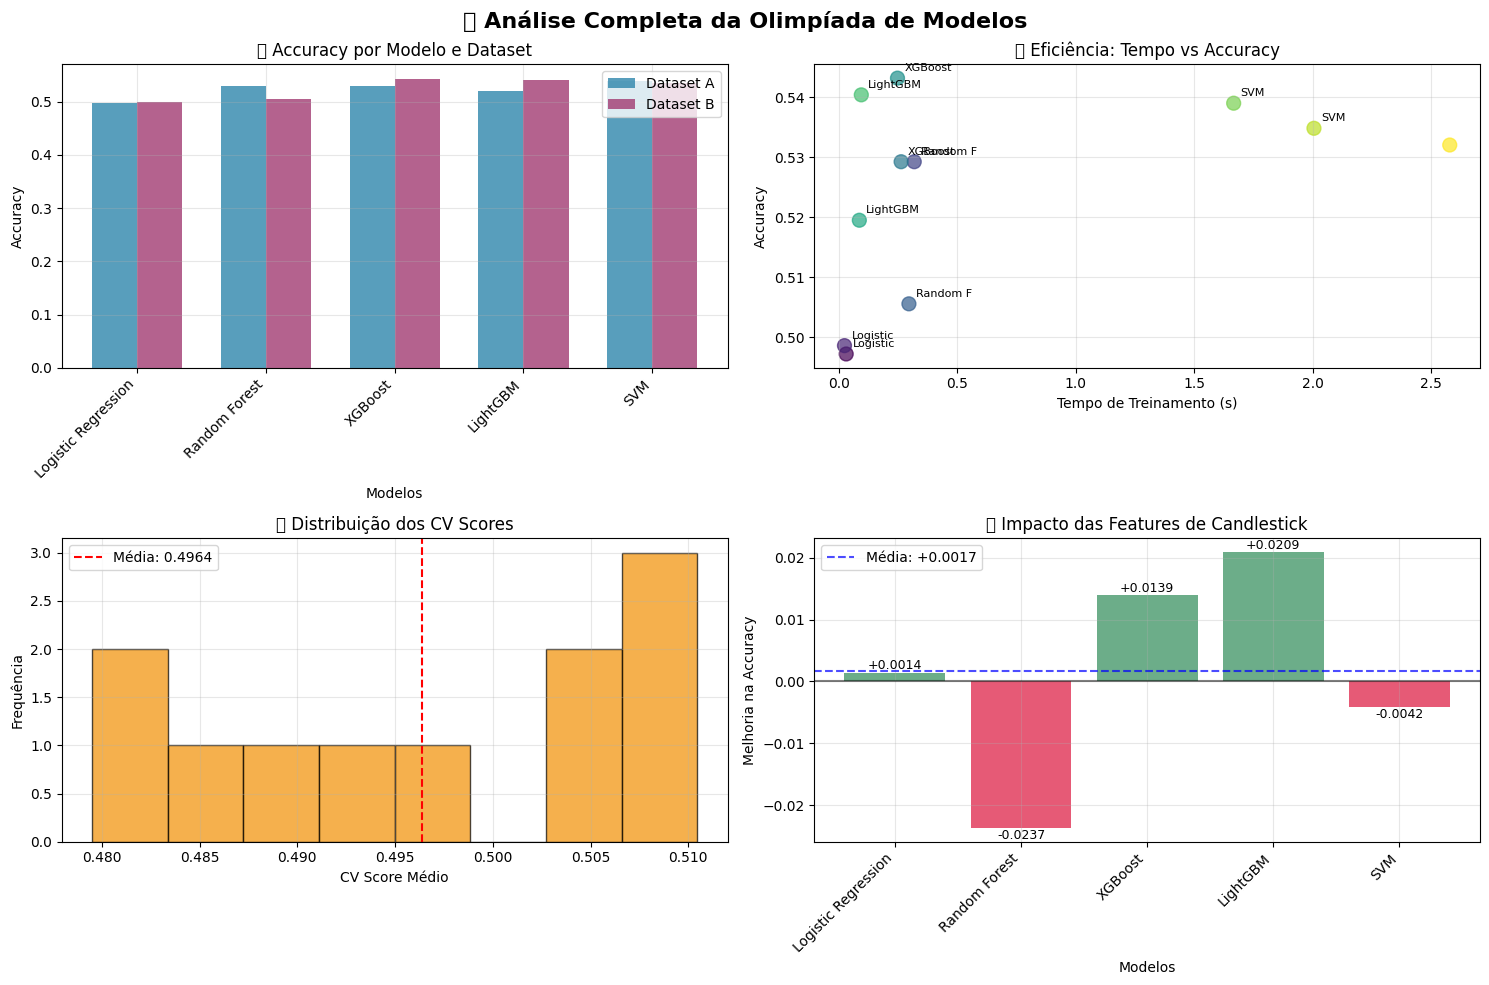


‚úÖ Gr√°ficos gerados com sucesso:
   üìà Accuracy por Modelo e Dataset
   ‚è±Ô∏è Tempo vs Accuracy
   üìä Distribui√ß√£o de CV Scores
   üïØÔ∏è Impacto das Features de Candlestick

üìà Estat√≠sticas do Impacto Candlestick:
   Melhoria m√©dia: +0.0017
   Desvio padr√£o: 0.0155
   Modelos que melhoraram: 3/5

üéØ An√°lise visual conclu√≠da com sucesso!


In [18]:
# VISUALIZA√á√ïES AVAN√áADAS DOS RESULTADOS
print("üìä CRIANDO VISUALIZA√á√ïES DOS RESULTADOS")

if results and len(results) > 0:
    results_df = pd.DataFrame(results)
    
    # Configurar figura com subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('üèÜ An√°lise Completa da Olimp√≠ada de Modelos', fontsize=16, fontweight='bold')
    
    # 1. Accuracy por Modelo e Dataset
    ax1 = axes[0, 0]
    models_list = [m for m in results_df['model_name'].unique() if m != 'Voting Classifier']
    datasets_list = results_df['dataset'].unique()
    
    x = np.arange(len(models_list))
    width = 0.35
    
    colors = ['#2E86AB', '#A23B72', '#F18F01']
    for i, dataset in enumerate(datasets_list):
        dataset_data = results_df[results_df['dataset'] == dataset]
        accuracies = []
        
        for model in models_list:
            model_data = dataset_data[dataset_data['model_name'] == model]
            if len(model_data) > 0:
                accuracies.append(model_data.iloc[0]['accuracy'])
            else:
                accuracies.append(0)
        
        ax1.bar(x + i*width, accuracies, width, label=dataset, alpha=0.8, color=colors[i % len(colors)])
    
    ax1.set_xlabel('Modelos')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('üìà Accuracy por Modelo e Dataset')
    ax1.set_xticks(x + width/2)
    ax1.set_xticklabels(models_list, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Tempo vs Accuracy (scatter plot)
    ax2 = axes[0, 1]
    times = [r['training_time'] for r in results]
    accuracies = [r['accuracy'] for r in results]
    models = [r['model_name'] for r in results]
    
    scatter = ax2.scatter(times, accuracies, alpha=0.7, s=100, c=range(len(times)), cmap='viridis')
    
    # Adicionar labels aos pontos
    for i, model in enumerate(models):
        if model != 'Voting Classifier':  # Evitar sobreposi√ß√£o
            ax2.annotate(model[:8], (times[i], accuracies[i]), 
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax2.set_xlabel('Tempo de Treinamento (s)')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('‚è±Ô∏è Efici√™ncia: Tempo vs Accuracy')
    ax2.grid(True, alpha=0.3)
    
    # 3. Distribui√ß√£o de Cross-Validation Scores
    ax3 = axes[1, 0]
    cv_scores = [r['cv_mean'] for r in results if r['cv_mean'] is not None]
    if cv_scores:
        ax3.hist(cv_scores, bins=8, alpha=0.7, edgecolor='black', color='#F18F01')
        ax3.axvline(np.mean(cv_scores), color='red', linestyle='--', 
                   label=f'M√©dia: {np.mean(cv_scores):.4f}')
        ax3.set_xlabel('CV Score M√©dio')
        ax3.set_ylabel('Frequ√™ncia')
        ax3.set_title('üìä Distribui√ß√£o dos CV Scores')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # 4. Impacto das Features de Candlestick
    ax4 = axes[1, 1]
    candlestick_impact = []
    models_impact = []
    
    for model_name in results_df['model_name'].unique():
        if model_name != 'Voting Classifier':
            model_results = results_df[results_df['model_name'] == model_name]
            if len(model_results) == 2:
                baseline = model_results[model_results['dataset'] == 'Dataset A'].iloc[0]
                enriched = model_results[model_results['dataset'] == 'Dataset B'].iloc[0]
                improvement = enriched['accuracy'] - baseline['accuracy']
                candlestick_impact.append(improvement)
                models_impact.append(model_name)
    
    if candlestick_impact:
        colors = ['#2E8B57' if x > 0 else '#DC143C' for x in candlestick_impact]
        bars = ax4.bar(models_impact, candlestick_impact, color=colors, alpha=0.7)
        
        # Adicionar valores nas barras
        for bar, value in zip(bars, candlestick_impact):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + (0.0001 if height > 0 else -0.0001),
                    f'{value:+.4f}', ha='center', va='bottom' if height > 0 else 'top', fontsize=9)
        
        ax4.set_xlabel('Modelos')
        ax4.set_ylabel('Melhoria na Accuracy')
        ax4.set_title('üïØÔ∏è Impacto das Features de Candlestick')
        ax4.set_xticklabels(models_impact, rotation=45, ha='right')
        ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax4.grid(True, alpha=0.3)
        
        # Adicionar linha de m√©dia
        avg_impact = np.mean(candlestick_impact)
        ax4.axhline(y=avg_impact, color='blue', linestyle='--', alpha=0.7,
                   label=f'M√©dia: {avg_impact:+.4f}')
        ax4.legend()
    
    plt.tight_layout()
    plt.show()
    
    print("\n‚úÖ Gr√°ficos gerados com sucesso:")
    print("   üìà Accuracy por Modelo e Dataset")
    print("   ‚è±Ô∏è Tempo vs Accuracy")
    print("   üìä Distribui√ß√£o de CV Scores")
    print("   üïØÔ∏è Impacto das Features de Candlestick")
    
    # Estat√≠sticas adicionais
    if candlestick_impact:
        print(f"\nüìà Estat√≠sticas do Impacto Candlestick:")
        print(f"   Melhoria m√©dia: {np.mean(candlestick_impact):+.4f}")
        print(f"   Desvio padr√£o: {np.std(candlestick_impact):.4f}")
        print(f"   Modelos que melhoraram: {sum(1 for x in candlestick_impact if x > 0)}/{len(candlestick_impact)}")

else:
    print("‚ùå Nenhum resultado dispon√≠vel para visualiza√ß√£o")

print(f"\nüéØ An√°lise visual conclu√≠da com sucesso!")